In [1]:
#Set up the directory
new_dir = "/home/student/data_5000_project/programs/R-CNN/"
%cd $new_dir
!pwd

/home/student/data_5000_project/programs/R-CNN
/home/student/data_5000_project/programs/R-CNN


In [2]:
!python -V

Python 3.6.10 :: Anaconda, Inc.


Run
!sudo git clone https://github.com/matterport/Mask_RCNN.git

Data is in 
/home/student/data_5000_project/data/images/construction_types/processed/opus_incertum

In [5]:
!pwd


/home/student/data_5000_project/programs/R-CNN/Mask_RCNN


In [4]:
#if not /home/student/data_5000_project/programs/R-CNN/Mask_RCNN
%cd Mask_RCNN

/home/student/data_5000_project/programs/R-CNN/Mask_RCNN


In [5]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling bu

In [6]:
!pip install scikit-image

In [4]:
!pip show mask-rcnn
!pwd

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /home/student/anaconda3/envs/tensorflow/lib/python3.6/site-packages/mask_rcnn-2.1-py3.6.egg
Requires: 
Required-by: 
/home/student/data_5000_project/programs/R-CNN/Mask_RCNN


In [5]:
# split into train and test set
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset

# class that defines and loads the opus_incertum dataset
class ObjectDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "opus_incertum")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            
            # skip all images after 400 if we are building the train set
            if is_train and int(image_id) >= 400:
                continue
            # skip all images before 400 if we are building the test/val set
            if not is_train and int(image_id) < 400:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    # count bounding boxes from an annotation file
    def count_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        box_count=0
        for box in root.findall('.//bndbox'):
            box_count=box_count+1
        return box_count

    
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('opus_incertum'))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# train set
train_set = ObjectDataset()
# opus_incertum - change
train_set.load_dataset('/home/student/data_5000_project/data/images/construction_types/processed/opus_incertum', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = ObjectDataset()
# opus_incertum - change
test_set.load_dataset('/home/student/data_5000_project/data/images/construction_types/processed/opus_incertum', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 160
Test: 40


# Count Boxes for Confusion Matrix

In [6]:
import inspect
#print(inspect.getmembers(train_set))
#print(train_set)
print("Train")
print('Train images: %d' % len(train_set.image_ids))
boxes_total = 0
for i in train_set.image_info:
    #print(i['annotation'])
    boxes_count = train_set.count_boxes(i['annotation'])
    boxes_total = boxes_total + boxes_count
    #print(boxes_count)
print('Train boxes: %d' % boxes_total)

print("Test")
print('Test images: %d' % len(test_set.image_ids))
boxes_total = 0
for i in test_set.image_info:
    #print(i['annotation'])
    boxes_count = train_set.count_boxes(i['annotation'])
    boxes_total = boxes_total + boxes_count
    #print(boxes_count)
print('Test boxes: %d' % boxes_total)

Train
Train images: 160
Train boxes: 306
Test
Test images: 40
Test boxes: 61


(768, 1024, 3)
(768, 1024, 1)


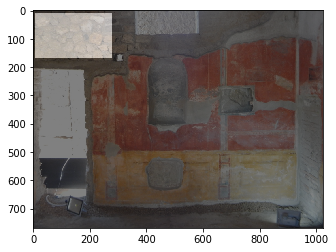

In [7]:
# plot one photograph and mask
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from matplotlib import pyplot



# train set
train_set = ObjectDataset()
#opus_incertum
train_set.load_dataset('/home/student/data_5000_project/data/images/construction_types/processed/opus_incertum', is_train=True)
train_set.prepare()
# load an image
image_id = 8
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()

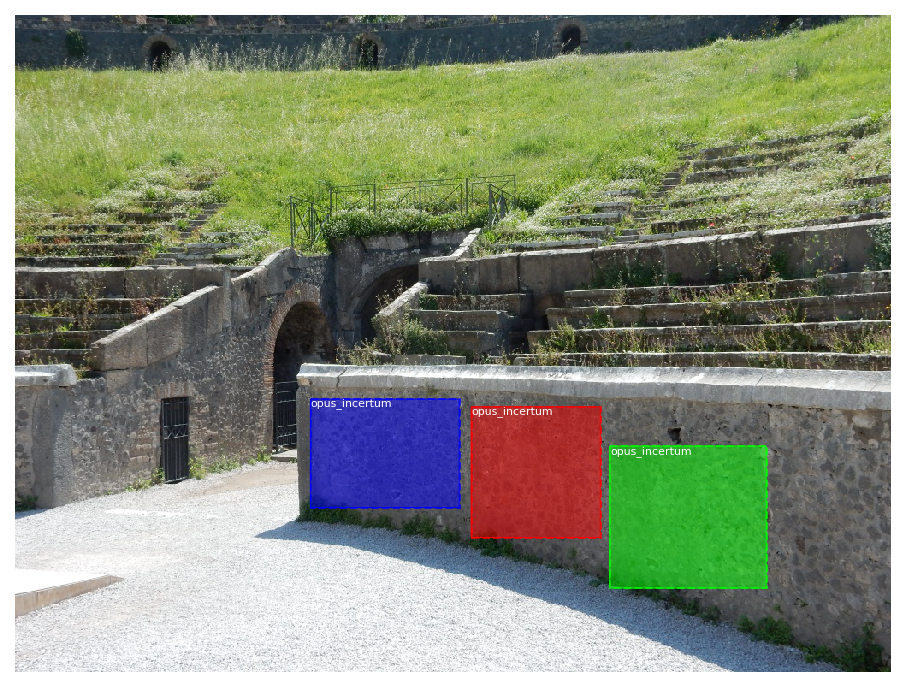

In [8]:
# display image with masks and bounding boxes
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset

from mrcnn.utils import extract_bboxes

# train set
train_set = ObjectDataset()
train_set.load_dataset('/home/student/data_5000_project/data/images/construction_types/processed/opus_incertum', is_train=True)
train_set.prepare()
# define image id
image_id = 6
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [ ]:
print(image)



In [23]:
# fit a mask rcnn on the opus_incertum dataset
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN



# define a configuration for the model
class ObjectConfig(Config):
    # define the name of the configuration
    NAME = "opus_incertum_cfg"
    # number of classes (background + opus_incertum)
    NUM_CLASSES = 1 + 1
    # number of training steps per epoch
    STEPS_PER_EPOCH = 160
    VALIDATION_STEPS = 40

# prepare train set
train_set = ObjectDataset()
train_set.load_dataset('/home/student/data_5000_project/data/images/construction_types/processed/opus_incertum', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = ObjectDataset()
test_set.load_dataset('/home/student/data_5000_project/data/images/construction_types/processed/opus_incertum', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# prepare config
config = ObjectConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=20, layers='heads')

#Thanks to Renu Khandelwal https://towardsdatascience.com/object-detection-using-mask-r-cnn-on-a-custom-dataset-4f79ab692f6d 
history = model.keras_model.history.history 

Train: 160
Test: 40

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14

/home/student/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/student/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
160/160 [==============================] - 132s 822ms/step - loss: 1.6731 - rpn_class_loss: 0.0654 - rpn_bbox_loss: 0.4925 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.5585 - mrcnn_mask_loss: 0.4657 - val_loss: 1.6099 - val_rpn_class_loss: 0.0435 - val_rpn_bbox_loss: 0.5492 - val_mrcnn_class_loss: 0.0595 - val_mrcnn_bbox_loss: 0.5990 - val_mrcnn_mask_loss: 0.3586
Epoch 2/20
160/160 [==============================] - 91s 572ms/step - loss: 1.1753 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.2838 - mrcnn_class_loss: 0.1111 - mrcnn_bbox_loss: 0.3920 - mrcnn_mask_loss: 0.3672 - val_loss: 1.1347 - val_rpn_class_loss: 0.0214 - val_rpn_bbox_loss: 0.2912 - val_mrcnn_class_loss: 0.0577 - val_mrcnn_bbox_loss: 0.4593 - val_mrcnn_mask_loss: 0.3050
Epoch 3/20
160/160 [==============================] - 90s 565ms/step - loss: 1.0266 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.2553 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.3341 - mrcnn_mask_loss: 0.3399 - val_loss: 1.7589 - val_rpn_

Text(0.5, 1.0, 'Still working on this')

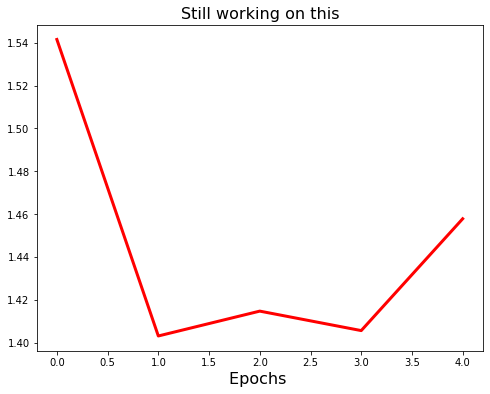

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
plt.plot(history['val_loss'],'r',linewidth=3.0)
#plt.plot(history.history['val_acc'],'b',linewidth=3.0)
#plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
#plt.ylabel('Accuracy',fontsize=16)
plt.title('Still working on this',fontsize=16)

In [15]:
print(history)

{'val_loss': [1.541502872109413, 1.4031053543090821, 1.414706139266491, 1.4056186228990555, 1.457812163233757], 'val_rpn_class_loss': [0.034375204145908354, 0.028933454398065807, 0.015945476456545295, 0.02693710394669324, 0.016935845045372842], 'val_rpn_bbox_loss': [0.5716827653348446, 0.3648504361510277, 0.5590641133487224, 0.5288925837725401, 0.4690914899110794], 'val_mrcnn_class_loss': [0.07605075594037772, 0.10473331548273564, 0.04557628291659057, 0.08613347597420215, 0.06212899945676327], 'val_mrcnn_bbox_loss': [0.5145604908466339, 0.5610701851546764, 0.458904554694891, 0.4182634301483631, 0.503749317675829], 'val_mrcnn_mask_loss': [0.34483209252357483, 0.34351643100380896, 0.3352141745388508, 0.34539046362042425, 0.40590492486953733], 'loss': [1.6332384683191776, 1.2242084495723247, 1.0164872027933598, 1.0665173321962356, 0.966090683452785], 'rpn_class_loss': [0.058899260952603075, 0.028588223509723322, 0.018493037234293297, 0.019935121340677143, 0.016222180165641475], 'rpn_bbox_

In [10]:
# evaluate the mask rcnn model on the opus_incertum dataset
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image



# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "opus_incertum_cfg"
	# number of classes (background + opus_incertum)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP

# load the train dataset
train_set = ObjectDataset()
train_set.load_dataset('/home/student/data_5000_project/data/images/construction_types/processed/opus_incertum', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# load the test dataset
test_set = ObjectDataset()
test_set.load_dataset('/home/student/data_5000_project/data/images/construction_types/processed/opus_incertum', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# create config
cfg = PredictionConfig()
# define the model
#cfg_name = 'cfg20200208T0930'
#cfg_name = 'cfg20200301T1702'
#cfg_name = ''
cfg_name = 'cfg20200307T0901'
print(cfg_name)
model = MaskRCNN(mode='inference', model_dir='/opus_incertum_'+cfg_name, config=cfg)
# load model weights
model.load_weights('/home/student/data_5000_project/programs/R-CNN/Mask_RCNN/opus_incertum_'+cfg_name+'/mask_rcnn_opus_incertum_cfg_0005.h5', by_name=True)

# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Using TensorFlow backend.


Train: 160
Test: 40
cfg20200307T0901
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Re-starting from epoch 5


ResourceExhaustedError: OOM when allocating tensor with shape[1,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv1/convolution}} = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 2, 2], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv1/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv1/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node roi_align_mask/strided_slice_17/_4277}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3068_roi_align_mask/strided_slice_17", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [11]:
# detect opus_incertum in photos 
import os
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset



# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "opus_incertum_cfg"
    # number of classes (background + opus_incertum)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, image_prediction_folder, n_images=10):
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        #pyplot.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        #pyplot.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        pyplot.savefig(image_prediction_folder+"/"+str(i)+"_actual.jpg")
        pyplot.show()

        pyplot.imshow(image)
        pyplot.title('Predicted')
        ax = pyplot.gca()
        # plot each box
        boxes_predicted = 0
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
            boxes_predicted = boxes_predicted +1
    # show the figure
        pyplot.savefig(image_prediction_folder+"/"+str(i)+"_predicted.jpg")
        pyplot.show()
        print ("boxes_predicted: %d" % boxes_predicted)


In [ ]:

# load the train dataset
train_set = ObjectDataset()
train_set.load_dataset('/home/student/data_5000_project/data/images/construction_types/processed/opus_incertum', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# load the test dataset
test_set = ObjectDataset()
test_set.load_dataset('/home/student/data_5000_project/data/images/construction_types/processed/opus_incertum', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
#cfg_name = 'cfg20200301T1702'
#cfg_name = ''
cfg_name = 'cfg20200307T0901'
model_path = '/home/student/data_5000_project/programs/R-CNN/Mask_RCNN/opus_incertum_'+cfg_name+'/mask_rcnn_opus_incertum_cfg_0005.h5'
    
model.load_weights(model_path, by_name=True)
image_prediction_folder = '/home/student/data_5000_project/data/images/construction_types/processed/opus_incertum/predictions/'+cfg_name
if not os.path.exists(image_prediction_folder):
    os.mkdir(image_prediction_folder)

# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, cfg, image_prediction_folder,1)
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg, image_prediction_folder,1)

Train: 160
Test: 40


In [1]:
# display image with masks and bounding boxes
from os import listdir
import skimage
import random
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights

model_path = '/home/student/data_5000_project/programs/R-CNN/Mask_RCNN/opus_incertum_'+cfg_name+'/mask_rcnn_opus_incertum_cfg_0005.h5'
    
model.load_weights(model_path, by_name=True)

image_for_prediction_folder = '/storage/box/Pompeii in Pictures/Pompeii Ferebee/Pompeii/'

image_prediction_folder = '/home/student/data_5000_project/data/images/construction_types/processed/opus_incertum/predictions/'+cfg_name+"/unknown/"
if not os.path.exists(image_prediction_folder):
    os.mkdir(image_prediction_folder)

# Load a random image from the images folder
file_names = next(os.walk(image_for_prediction_folder))[2]
#print(file_names)
class_names = ["opus_incertum","opus_incertum","opus_incertum"]
for cn in range(1,20):
    
    image = skimage.io.imread(os.path.join(image_for_prediction_folder, random.choice(file_names)))
    # Run detection
    results = model.detect([image], verbose=1)
    # Visualize results
    r = results[0]
    image2= display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])


/home/student/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/student/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/student/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/student/anaconda3/envs/te

NameError: name 'PredictionConfig' is not defined

In [2]:
file_names = next(os.walk(image_for_prediction_folder))[2]
#print(file_names)
test_file_names=[]
for cn in range(0,100):
    test_file_names.append(random.choice(file_names))

print(test_file_names)


NameError: name 'os' is not defined

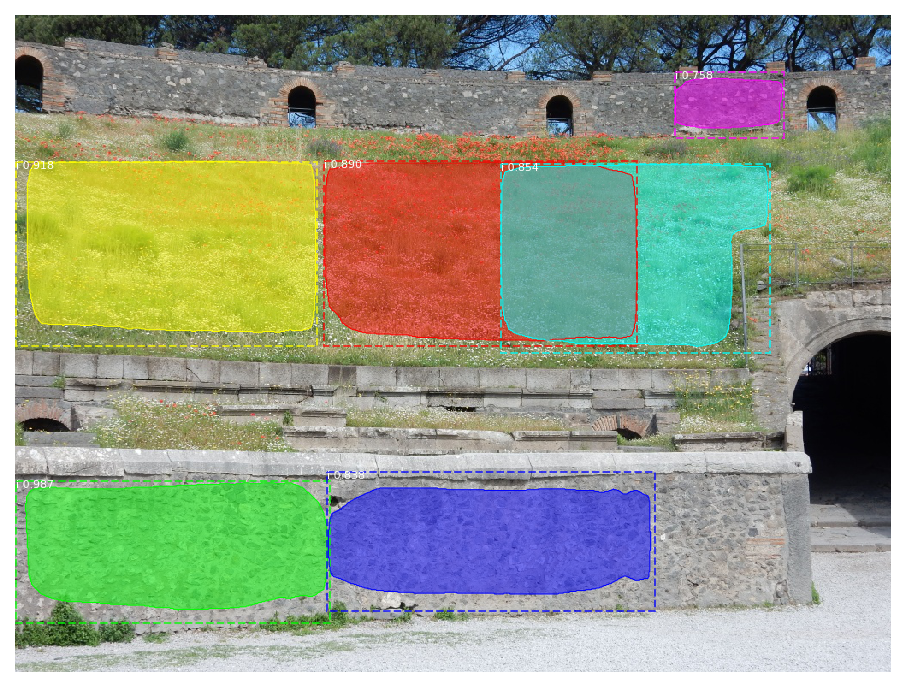

In [11]:
display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            "oi", r['scores'])